In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import numpy as np
import os
from imageio import imread
from PIL import Image
from numpy import asarray
import cv2
import imageio
import datetime
import os

In [17]:
import matplotlib.pyplot as plt

In [18]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [19]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU,TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D,AveragePooling3D
from keras.layers import TimeDistributed, Conv2D, Dense, MaxPooling2D, LSTM, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

In [92]:
train_doc = np.random.permutation(open('/content/drive/MyDrive/Cv-data/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/MyDrive/Cv-data/Project_data/val.csv').readlines())
batch_size = 20 #experiment with the batch size
print(len(train_doc))

663


Number of frames,height,width of the image

In [103]:
x = 30
y = 140
z = 140

In [104]:
def plot_history(history):
  plt.plot(history.history['categorical_accuracy'])
  plt.plot(history.history['val_categorical_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

custom genearetor

In [94]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0,x)] #[x for x in range(0,x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size  # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    cropped_image = image[10:280, 10:280]
                    temp = cv2.resize(cropped_image,(y,z))
                    temp = temp/255. #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = temp[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = temp[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = temp[:,:,2] #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    temp = cv2.resize(cropped_image,(y,z))
                    temp = temp/255. #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = temp[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = temp[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = temp[:,:,2] #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


In [105]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Cv-data/Project_data/train'
val_path = '/content/drive/MyDrive/Cv-data/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [106]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [107]:
def sample_steps(sample_num_train_sequences,sample_num_val_sequences):
  if (sample_num_train_sequences%batch_size) == 0:
    sample_steps_per_epoch = int(sample_num_train_sequences/batch_size)
  else:
    sample_steps_per_epoch = (sample_num_train_sequences//batch_size) + 1

  if (num_val_sequences%batch_size) == 0:
    sample_validation_steps = int(sample_num_val_sequences/batch_size)
  else:
    sample_validation_steps = (sample_num_val_sequences//batch_size) + 1
  return sample_steps_per_epoch,sample_validation_steps

In [108]:
def sample_sequences(sample_train,sample_test,numberofepochs):
  curr_dt_time = datetime.datetime.now()
  train_path = '/content/drive/MyDrive/Cv-data/Project_data/train'
  val_path = '/content/drive/MyDrive/Cv-data/Project_data/val'
  sample_num_train_sequences = len(train_doc[:sample_train])
  print('# training sequences =', sample_num_train_sequences)
  sample_num_val_sequences = len(val_doc[:sample_test])
  print('# validation sequences =', sample_num_val_sequences)
  num_epochs = numberofepochs# choose the number of epochs
  print ('# epochs =', num_epochs)
  return sample_num_train_sequences,sample_num_val_sequences

In [109]:
def sample_data_generator(sample_train,sample_test):
  sample_train_generator=generator(train_path,train_doc[:sample_train],batch_size)
  sample_val_generator = generator(val_path, val_doc[:sample_test], batch_size)
  return sample_train_generator,sample_val_generator

In [110]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

**Model1 conv3d**

In [30]:
def conv3d_modelbuilder():
  conv3d_model=Sequential()
  conv3d_model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(x,y,z,3)))
  conv3d_model.add(MaxPooling3D(pool_size=(2, 2, 2)))
  conv3d_model.add(BatchNormalization(center=True, scale=True))
  conv3d_model.add(Dropout(0.5))
  conv3d_model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  conv3d_model.add(MaxPooling3D(pool_size=(2, 2, 2)))
  conv3d_model.add(BatchNormalization(center=True, scale=True))
  conv3d_model.add(Dropout(0.5))
  conv3d_model.add(Flatten())
  conv3d_model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
  conv3d_model.add(Dense(5, activation='softmax'))
  return conv3d_model

In [31]:


#write your model here
conv3d_model1=conv3d_modelbuilder()


In [32]:
optimiser = tf.keras.optimizers.Adam(0.01)    #write your optimizer
conv3d_model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (conv3d_model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 13, 138, 138, 32)  2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 6, 69, 69, 32)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 6, 69, 69, 32)    128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 6, 69, 69, 32)     0         
                                                                 
 conv3d_1 (Conv3D)           (None, 4, 67, 67, 64)     55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 2, 33, 33, 64)    0

In [33]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [34]:
sample_train_generator,sample_val_generator=sample_data_generator(200,50)
sample_num_train_sequences,sample_num_val_sequences=sample_sequences(200,50,20)
sample_steps_per_epoch,sample_validation_steps=sample_steps(sample_num_train_sequences,sample_num_val_sequences)

# training sequences = 200
# validation sequences = 50
# epochs = 20


In [35]:
#images per video->x=15,batchsize=32
history=conv3d_model1.fit(sample_train_generator, steps_per_epoch=sample_steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=sample_val_generator, 
                    validation_steps=sample_validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Cv-data/Project_data/train ; batch size = 32
Epoch 1/20
7/7 [==============================] - ETA: 0s - loss: 160.7101 - categorical_accuracy: 0.3650  Source path =  /content/drive/MyDrive/Cv-data/Project_data/val ; batch size = 32
Batch:  2 Index: 32

Epoch 1: saving model to model_init_2022-05-1808_52_43.885540/model-00001-160.71008-0.36500-9526.73535-0.22000.h5
7/7 [==============================] - 698s 114s/step - loss: 160.7101 - categorical_accuracy: 0.3650 - val_loss: 9526.7354 - val_categorical_accuracy: 0.2200 - lr: 0.0100
Epoch 2/20
7/7 [==============================] - ETA: 0s - loss: 64.1629 - categorical_accuracy: 0.4821Batch:  3 Index: 18

Epoch 2: saving model to model_init_2022-05-1808_52_43.885540/model-00002-64.16290-0.48214-11371.86914-0.15625.h5
7/7 [==============================] - 36s 6s/step - loss: 64.1629 - categorical_accuracy: 0.4821 - val_loss: 11371.8691 - val_categorical_accuracy: 0.1562 - lr: 0.0100
Epoch 3/20
7/7

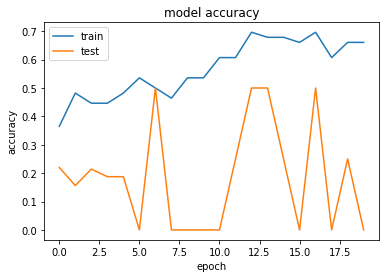

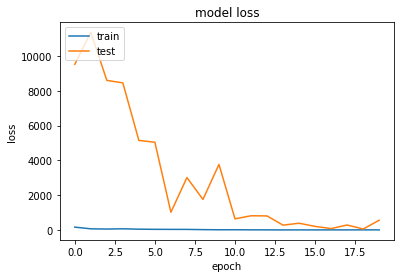

In [36]:
plot_history(history)

**Model1 conclusion:** The model performed well on the training data set very poor  on the training data set ,so the model is overfitting

**Model2:**Adding one more dense net layer 

Training data: 200 samples
validation data:50 samples
Epochs:20

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

In [37]:
def conv3d_modelbuilder2():
  conv3d_model2= Sequential()
  conv3d_model2.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(x,y,z,3)))
  conv3d_model2.add(MaxPooling3D(pool_size=(2, 2, 2)))
  conv3d_model2.add(BatchNormalization(center=True, scale=True))
  conv3d_model2.add(Dropout(0.5))
  conv3d_model2.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  conv3d_model2.add(MaxPooling3D(pool_size=(2, 2, 2)))
  conv3d_model2.add(BatchNormalization(center=True, scale=True))
  conv3d_model2.add(Dropout(0.5))
  conv3d_model2.add(Flatten())
  conv3d_model2.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
  conv3d_model2.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
  conv3d_model2.add(Dense(5, activation='softmax'))
  return conv3d_model2

In [38]:
conv3d_model2=conv3d_modelbuilder2()

In [39]:
optimiser = tf.keras.optimizers.Adam(0.001)    #write your optimizer
conv3d_model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (conv3d_model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 13, 138, 138, 32)  2624      
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 6, 69, 69, 32)    0         
 3D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 6, 69, 69, 32)    128       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 6, 69, 69, 32)     0         
                                                                 
 conv3d_3 (Conv3D)           (None, 4, 67, 67, 64)     55360     
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 2, 33, 33, 64)   

In [40]:
sample_train_generator,sample_val_generator=sample_data_generator(200,50)
sample_num_train_sequences,sample_num_val_sequences=sample_sequences(200,50,20)
sample_steps_per_epoch,sample_validation_steps=sample_steps(sample_num_train_sequences,sample_num_val_sequences)

# training sequences = 200
# validation sequences = 50
# epochs = 20


In [41]:
#images per video->x=15,batchsize=32
history=conv3d_model2.fit(sample_train_generator, steps_per_epoch=sample_steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=sample_val_generator, 
                    validation_steps=sample_validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Cv-data/Project_data/train ; batch size = 32
Epoch 1/20
7/7 [==============================] - ETA: 0s - loss: 16.6630 - categorical_accuracy: 0.3050Source path =  /content/drive/MyDrive/Cv-data/Project_data/val ; batch size = 32
Batch:  2 Index: 32

Epoch 1: saving model to model_init_2022-05-1808_52_43.885540/model-00001-16.66296-0.30500-153.96581-0.20000.h5
7/7 [==============================] - 19s 3s/step - loss: 16.6630 - categorical_accuracy: 0.3050 - val_loss: 153.9658 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/20
7/7 [==============================] - ETA: 0s - loss: 10.3506 - categorical_accuracy: 0.5357Batch:  3 Index: 18

Epoch 2: saving model to model_init_2022-05-1808_52_43.885540/model-00002-10.35056-0.53571-73.76429-0.25000.h5
7/7 [==============================] - 8s 1s/step - loss: 10.3506 - categorical_accuracy: 0.5357 - val_loss: 73.7643 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/20
7/7 [===============

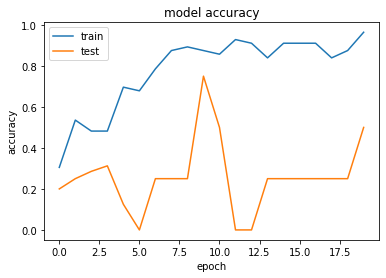

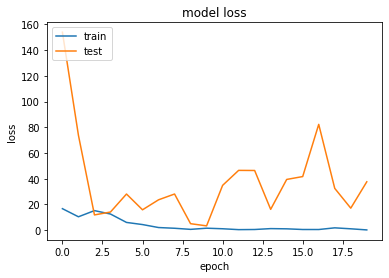

In [42]:
plot_history(history)

**Model2 Conclusion**: The model performed well on the training data set and average on validation data set 
Training accuracy 0.96
validation accuracy:0.50

**Model3**: Training the model2(cov3d) on more samples to check the performance

Training:400
validation:100
Epochs:20

In [54]:
# increasing more samples
sample_train_generator,sample_val_generator=sample_data_generator(400,100)

In [55]:
sample_num_train_sequences,sample_num_val_sequences=sample_sequences(400,100,20)

# training sequences = 400
# validation sequences = 100
# epochs = 20


In [56]:
sample_steps_per_epoch,sample_validation_steps=sample_steps(sample_num_train_sequences,sample_num_val_sequences)

In [57]:
conv3d_model3=conv3d_modelbuilder2()

In [58]:
optimiser = tf.keras.optimizers.Adam(0.001)    #write your optimizer
conv3d_model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (conv3d_model3.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 13, 138, 138, 32)  2624      
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 6, 69, 69, 32)    0         
 3D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 6, 69, 69, 32)    128       
 hNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (None, 6, 69, 69, 32)     0         
                                                                 
 conv3d_9 (Conv3D)           (None, 4, 67, 67, 64)     55360     
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 2, 33, 33, 64)   

In [59]:
#images per video->x=15,batchsize=32
history=conv3d_model2.fit(sample_train_generator, steps_per_epoch=sample_steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=sample_val_generator, 
                    validation_steps=sample_validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Cv-data/Project_data/train ; batch size = 32
Epoch 1/20
13/13 [==============================] - ETA: 0s - loss: 4.8892 - categorical_accuracy: 0.6425Source path =  /content/drive/MyDrive/Cv-data/Project_data/val ; batch size = 32
Batch:  4 Index: 32

Epoch 1: saving model to model_init_2022-05-1808_52_43.885540/model-00001-4.88916-0.64250-15.85370-0.36000.h5
13/13 [==============================] - 35s 3s/step - loss: 4.8892 - categorical_accuracy: 0.6425 - val_loss: 15.8537 - val_categorical_accuracy: 0.3600 - lr: 0.0010
Epoch 2/20
13/13 [==============================] - ETA: 0s - loss: 3.3826 - categorical_accuracy: 0.7356
Epoch 2: saving model to model_init_2022-05-1808_52_43.885540/model-00002-3.38257-0.73558-14.09972-0.43750.h5
13/13 [==============================] - 16s 1s/step - loss: 3.3826 - categorical_accuracy: 0.7356 - val_loss: 14.0997 - val_categorical_accuracy: 0.4375 - lr: 0.0010
Epoch 3/20
13/13 [==============================] 

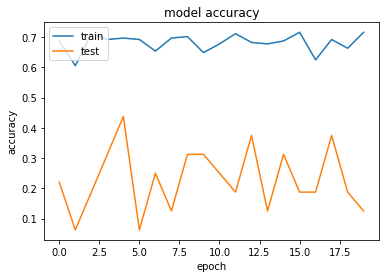

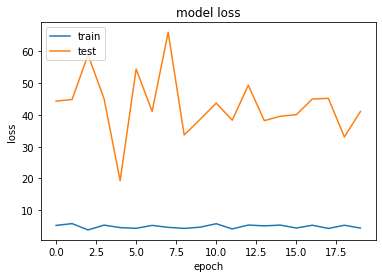

In [47]:
plot_history(history)

**Model3 conclusion**: The model performed well on training data but poor on validation data 

**Model4:**Reducing the number of neurons in hidden layers 

In [48]:
conv3d_model3= Sequential()
conv3d_model3.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(x,y,z,3)))
conv3d_model3.add(MaxPooling3D(pool_size=(2, 2, 2)))
conv3d_model3.add(BatchNormalization(center=True, scale=True))
conv3d_model3.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
conv3d_model3.add(MaxPooling3D(pool_size=(2, 2, 2)))
conv3d_model3.add(BatchNormalization(center=True, scale=True))
conv3d_model3.add(Dropout(0.5))
conv3d_model3.add(Flatten())
conv3d_model3.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
conv3d_model3.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
conv3d_model3.add(Dense(5, activation='softmax'))

In [49]:
sample_train_generator,sample_val_generator=sample_data_generator(200,50)
sample_num_train_sequences,sample_num_val_sequences=sample_sequences(200,50,20)
sample_steps_per_epoch,sample_validation_steps=sample_steps(sample_num_train_sequences,sample_num_val_sequences)

# training sequences = 200
# validation sequences = 50
# epochs = 20


In [50]:
optimiser = tf.keras.optimizers.Adam(0.005)    #write your optimizer
conv3d_model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (conv3d_model3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 13, 138, 138, 16)  1312      
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 6, 69, 69, 16)    0         
 3D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 6, 69, 69, 16)    64        
 hNormalization)                                                 
                                                                 
 conv3d_5 (Conv3D)           (None, 4, 67, 67, 32)     13856     
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 2, 33, 33, 32)    0         
 3D)                                                             
                                                      

In [51]:
#images per video->x=15,batchsize=32
history=conv3d_model3.fit(sample_train_generator, steps_per_epoch=sample_steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=sample_val_generator, 
                    validation_steps=sample_validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Cv-data/Project_data/train ; batch size = 32
Epoch 1/20
7/7 [==============================] - ETA: 0s - loss: 7.6382 - categorical_accuracy: 0.3300Source path =  /content/drive/MyDrive/Cv-data/Project_data/val ; batch size = 32
Batch:  2 Index: 32

Epoch 1: saving model to model_init_2022-05-1808_52_43.885540/model-00001-7.63820-0.33000-17.89145-0.30000.h5
7/7 [==============================] - 19s 3s/step - loss: 7.6382 - categorical_accuracy: 0.3300 - val_loss: 17.8914 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 2/20
7/7 [==============================] - ETA: 0s - loss: 2.4152 - categorical_accuracy: 0.6250Batch:  3 Index: 18

Epoch 2: saving model to model_init_2022-05-1808_52_43.885540/model-00002-2.41516-0.62500-19.82030-0.18750.h5
7/7 [==============================] - 8s 1s/step - loss: 2.4152 - categorical_accuracy: 0.6250 - val_loss: 19.8203 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 3/20
7/7 [=======================

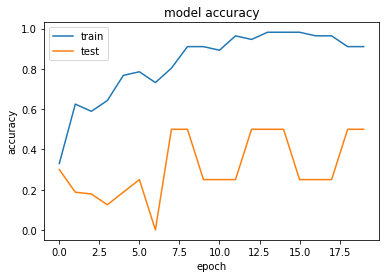

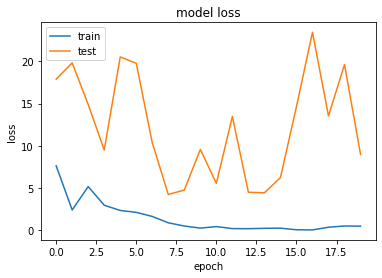

In [52]:
plot_history(history)

**Model4 conclusion**:
The model perform well on training data set and average on validation data set with validation accuracy of 50%

Model5:Convolution Gru 
Combination of CNN and Gru

In [60]:

conv_gru = Sequential([
                    TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                              input_shape=(x, y, z, 3)),
                    TimeDistributed(BatchNormalization()),
                    TimeDistributed(MaxPooling2D((2, 2))),

                    TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')),
                    TimeDistributed(BatchNormalization()),
                    TimeDistributed(MaxPooling2D((2, 2))),

                    TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')),
                    TimeDistributed(BatchNormalization()),
                    TimeDistributed(MaxPooling2D((2, 2))),

                    TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')),
                    TimeDistributed(BatchNormalization()),
                    TimeDistributed(MaxPooling2D((2, 2))),


                    TimeDistributed(Flatten()),


                    GRU(64),
                    Dropout(0.5),

                    Dense(64,activation='relu'),
                    Dropout(0.5),
                    Dense(5, activation='softmax')
])
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0005)
conv_gru.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [61]:
sample_train_generator,sample_val_generator=sample_data_generator(200,50)
sample_num_train_sequences,sample_num_val_sequences=sample_sequences(200,50,20)
sample_steps_per_epoch,sample_validation_steps=sample_steps(sample_num_train_sequences,sample_num_val_sequences)

# training sequences = 200
# validation sequences = 50
# epochs = 20


In [62]:
#images per video->x=15,batchsize=32
history=conv_gru.fit(sample_train_generator, steps_per_epoch=sample_steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=sample_val_generator, 
                    validation_steps=sample_validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Cv-data/Project_data/train ; batch size = 32
Epoch 1/20
7/7 [==============================] - ETA: 0s - loss: 1.9138 - categorical_accuracy: 0.2650Source path =  /content/drive/MyDrive/Cv-data/Project_data/val ; batch size = 32
Batch:  2 Index: 32

Epoch 1: saving model to model_init_2022-05-1808_52_43.885540/model-00001-1.91384-0.26500-1.58714-0.28000.h5
7/7 [==============================] - 21s 3s/step - loss: 1.9138 - categorical_accuracy: 0.2650 - val_loss: 1.5871 - val_categorical_accuracy: 0.2800 - lr: 5.0000e-04
Epoch 2/20
7/7 [==============================] - ETA: 0s - loss: 1.7787 - categorical_accuracy: 0.2679Batch:  3 Index: 18

Epoch 2: saving model to model_init_2022-05-1808_52_43.885540/model-00002-1.77873-0.26786-1.58422-0.25000.h5
7/7 [==============================] - 8s 1s/step - loss: 1.7787 - categorical_accuracy: 0.2679 - val_loss: 1.5842 - val_categorical_accuracy: 0.2500 - lr: 5.0000e-04
Epoch 3/20
7/7 [===================

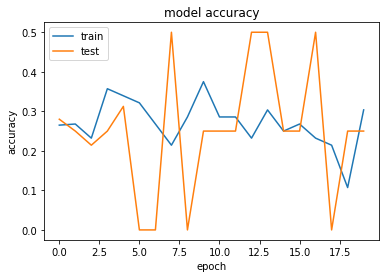

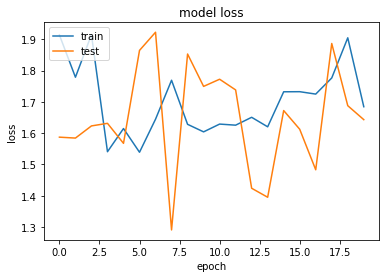

In [63]:
plot_history(history)

**Model 5 Conclusion:**Model performed poor on both training and validation data set 

**Model 6:CNN and Lstm**

In [68]:
def conv_lstm():
  conv_lstm = Sequential([
                    TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                              input_shape=(x, y, z, 3)),
                    TimeDistributed(BatchNormalization()),
                    TimeDistributed(MaxPooling2D((2, 2))),

                    TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')),
                    TimeDistributed(BatchNormalization()),
                    TimeDistributed(MaxPooling2D((2, 2))),

                    TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')),
                    TimeDistributed(BatchNormalization()),
                    TimeDistributed(MaxPooling2D((2, 2))),

                    TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')),
                    TimeDistributed(BatchNormalization()),
                    TimeDistributed(MaxPooling2D((2, 2))),


                    TimeDistributed(Flatten()),


                    LSTM(64),
                    Dropout(0.5),

                    Dense(64,activation='relu'),
                    Dropout(0.5),
                    Dense(5, activation='softmax')
  ])
  optimiser = tf.keras.optimizers.Adam(lr=0.0005)
  conv_lstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  return conv_lstm

In [65]:
sample_train_generator,sample_val_generator=sample_data_generator(200,50)
sample_num_train_sequences,sample_num_val_sequences=sample_sequences(200,50,20)
sample_steps_per_epoch,sample_validation_steps=sample_steps(sample_num_train_sequences,sample_num_val_sequences)

# training sequences = 200
# validation sequences = 50
# epochs = 20


In [66]:
history=conv_lstm.fit(sample_train_generator, steps_per_epoch=sample_steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=sample_val_generator, 
                    validation_steps=sample_validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Cv-data/Project_data/train ; batch size = 32
Epoch 1/20
7/7 [==============================] - ETA: 0s - loss: 1.7787 - categorical_accuracy: 0.1900Source path =  /content/drive/MyDrive/Cv-data/Project_data/val ; batch size = 32
Batch:  2 Index: 32

Epoch 1: saving model to model_init_2022-05-1808_52_43.885540/model-00001-1.77867-0.19000-1.60757-0.14000.h5
7/7 [==============================] - 21s 3s/step - loss: 1.7787 - categorical_accuracy: 0.1900 - val_loss: 1.6076 - val_categorical_accuracy: 0.1400 - lr: 5.0000e-04
Epoch 2/20
7/7 [==============================] - ETA: 0s - loss: 1.6237 - categorical_accuracy: 0.2679Batch:  3 Index: 18

Epoch 2: saving model to model_init_2022-05-1808_52_43.885540/model-00002-1.62368-0.26786-1.63635-0.15625.h5
7/7 [==============================] - 7s 1s/step - loss: 1.6237 - categorical_accuracy: 0.2679 - val_loss: 1.6363 - val_categorical_accuracy: 0.1562 - lr: 5.0000e-04
Epoch 3/20
7/7 [===================

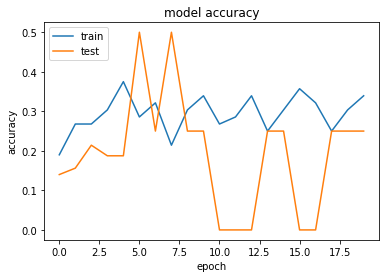

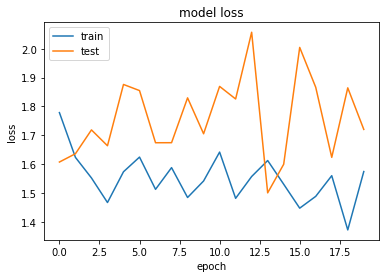

In [67]:
plot_history(history)

In [ ]:
# Training on more samples with x=18,y=140,z=140 

In [70]:
sample_train_generator,sample_val_generator=sample_data_generator(420,100)
sample_num_train_sequences,sample_num_val_sequences=sample_sequences(420,100,20)
sample_steps_per_epoch,sample_validation_steps=sample_steps(sample_num_train_sequences,sample_num_val_sequences)

# training sequences = 420
# validation sequences = 100
# epochs = 20


In [71]:
conv_lstm2=conv_lstm()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [72]:
#images per video->x=18,batchsize=32
history=conv_lstm2.fit(sample_train_generator, steps_per_epoch=sample_steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=sample_val_generator, 
                    validation_steps=sample_validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Cv-data/Project_data/train ; batch size = 32
Epoch 1/20
14/14 [==============================] - ETA: 0s - loss: 1.7169 - categorical_accuracy: 0.2143 Source path =  /content/drive/MyDrive/Cv-data/Project_data/val ; batch size = 32
Batch:  4 Index: 32

Epoch 1: saving model to model_init_2022-05-1808_52_43.885540/model-00001-1.71689-0.21429-1.61192-0.26000.h5
14/14 [==============================] - 407s 31s/step - loss: 1.7169 - categorical_accuracy: 0.2143 - val_loss: 1.6119 - val_categorical_accuracy: 0.2600 - lr: 5.0000e-04
Epoch 2/20
14/14 [==============================] - ETA: 0s - loss: 1.5062 - categorical_accuracy: 0.3393
Epoch 2: saving model to model_init_2022-05-1808_52_43.885540/model-00002-1.50618-0.33929-1.59844-0.37500.h5
14/14 [==============================] - 8s 641ms/step - loss: 1.5062 - categorical_accuracy: 0.3393 - val_loss: 1.5984 - val_categorical_accuracy: 0.3750 - lr: 5.0000e-04
Epoch 3/20
14/14 [=======================

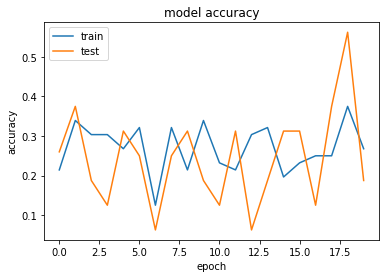

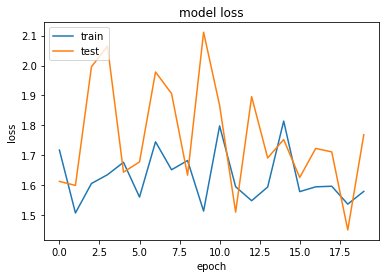

In [73]:
plot_history(history)

**Model 6 conclusion**: poor perfomance on both taining and vlidation tried with 200 ,50,20 -(training,validation,epochs)
420,50,20-(training,validation,epochs)
Increased number of frames to 18

**Model7:**
Mobinet transfer learning with Gru

In [116]:
from keras.applications import mobilenet
def mobilenet_model():
  mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
  mobilenet_model = Sequential()
  mobilenet_model.add(TimeDistributed(mobilenet_transfer,input_shape=(x,y,z,3)))
 
        
  mobilenet_model.add(TimeDistributed(BatchNormalization()))
  mobilenet_model.add(TimeDistributed(MaxPooling2D((2, 2))))
  mobilenet_model.add(TimeDistributed(Flatten()))

  mobilenet_model.add(GRU(64))
  mobilenet_model.add(Dropout(0.5))
        
  mobilenet_model.add(Dense(64,activation='relu'))
  mobilenet_model.add(Dropout(0.5))
        
  mobilenet_model.add(Dense(5, activation='softmax'))
  return mobilenet_model

In [75]:
sample_train_generator,sample_val_generator=sample_data_generator(420,100)
sample_num_train_sequences,sample_num_val_sequences=sample_sequences(420,100,20)
sample_steps_per_epoch,sample_validation_steps=sample_steps(sample_num_train_sequences,sample_num_val_sequences)

# training sequences = 420
# validation sequences = 100
# epochs = 20


In [76]:
mobilenet_model=mobilenet_model()
optimiser = tf.keras.optimizers.Adam(lr=0.0005)
mobilenet_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [77]:

#images per video->x=15,batchsize=32
history=mobilenet_model.fit(sample_train_generator, steps_per_epoch=sample_steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=sample_val_generator, 
                    validation_steps=sample_validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Cv-data/Project_data/train ; batch size = 32
Epoch 1/20
14/14 [==============================] - ETA: 0s - loss: 1.8802 - categorical_accuracy: 0.2714Source path =  /content/drive/MyDrive/Cv-data/Project_data/val ; batch size = 32
Batch:  4 Index: 32

Epoch 1: saving model to model_init_2022-05-1808_52_43.885540/model-00001-1.88022-0.27143-1.49168-0.39000.h5
14/14 [==============================] - 52s 3s/step - loss: 1.8802 - categorical_accuracy: 0.2714 - val_loss: 1.4917 - val_categorical_accuracy: 0.3900 - lr: 5.0000e-04
Epoch 2/20
14/14 [==============================] - ETA: 0s - loss: 1.5818 - categorical_accuracy: 0.3571
Epoch 2: saving model to model_init_2022-05-1808_52_43.885540/model-00002-1.58184-0.35714-1.51962-0.31250.h5
14/14 [==============================] - 7s 489ms/step - loss: 1.5818 - categorical_accuracy: 0.3571 - val_loss: 1.5196 - val_categorical_accuracy: 0.3125 - lr: 5.0000e-04
Epoch 3/20
14/14 [==========================

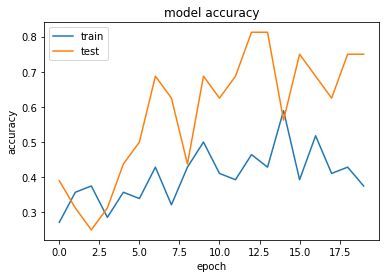

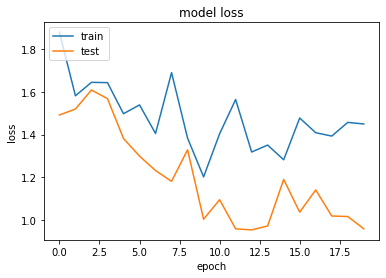

In [78]:
plot_history(history)

**Model7 conclusion:** Under performance validation accuracy is more than training accuracy

**Model 8:**Vgg16 transfer learning

In [80]:
from keras.applications.vgg16 import VGG16
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import TimeDistributed
from keras.layers import Dense, Input

In [88]:
def vgg_model():
  video = Input(shape=(x,y,z,3))
  cnn_base = VGG16(input_shape=(y,z,3),weights="imagenet",include_top=False)
  cnn_out = GlobalAveragePooling2D()(cnn_base.output)
  cnn = Model(cnn_base.input,cnn_out)
  cnn.trainable = False
  encoded_frames = TimeDistributed(cnn)(video)
  encoded_sequence = LSTM(256)(encoded_frames)
  hidden_layer = Dense(1024, activation='relu')(encoded_sequence)
  outputs = Dense(5, activation="softmax")(hidden_layer)
  transfer_learning_model = Model([video], outputs)
  return transfer_learning_model

In [82]:
transfer_learning_model=vgg_model()
optimiser = tf.keras.optimizers.Adam(0.005)    #write your optimizer
transfer_learning_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (transfer_learning_model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 18, 140, 140, 3)  0         
                             ]                                   
                                                                 
 time_distributed_43 (TimeDi  (None, 18, 512)          14714688  
 stributed)                                                      
                                                                 
 lstm_2 (LSTM)               (None, 256)               787456    
                                                                 
 dense_22 (Dense)            (None, 1024)              263168    
                                                                 
 dense_23 (Dense)            (None, 5)                 5125      
                                                                 
Total params: 15,770,437
Trainable params: 1,055,749
Non-tr

In [83]:
sample_train_generator,sample_val_generator=sample_data_generator(420,100)
sample_num_train_sequences,sample_num_val_sequences=sample_sequences(420,100,20)
sample_steps_per_epoch,sample_validation_steps=sample_steps(sample_num_train_sequences,sample_num_val_sequences)

# training sequences = 420
# validation sequences = 100
# epochs = 20


In [84]:
#images per video->x=15,batchsize=32
history=transfer_learning_model.fit(sample_train_generator, steps_per_epoch=sample_steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=sample_val_generator, 
                    validation_steps=sample_validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Cv-data/Project_data/train ; batch size = 32
Epoch 1/20
14/14 [==============================] - ETA: 0s - loss: 1.8814 - categorical_accuracy: 0.1905Source path =  /content/drive/MyDrive/Cv-data/Project_data/val ; batch size = 32
Batch:  4 Index: 32

Epoch 1: saving model to model_init_2022-05-1808_52_43.885540/model-00001-1.88140-0.19048-1.59048-0.21000.h5
14/14 [==============================] - 56s 3s/step - loss: 1.8814 - categorical_accuracy: 0.1905 - val_loss: 1.5905 - val_categorical_accuracy: 0.2100 - lr: 0.0050
Epoch 2/20
14/14 [==============================] - ETA: 0s - loss: 1.6003 - categorical_accuracy: 0.2857
Epoch 2: saving model to model_init_2022-05-1808_52_43.885540/model-00002-1.60027-0.28571-1.35226-0.43750.h5
14/14 [==============================] - 7s 533ms/step - loss: 1.6003 - categorical_accuracy: 0.2857 - val_loss: 1.3523 - val_categorical_accuracy: 0.4375 - lr: 0.0050
Epoch 3/20
14/14 [==============================] - 

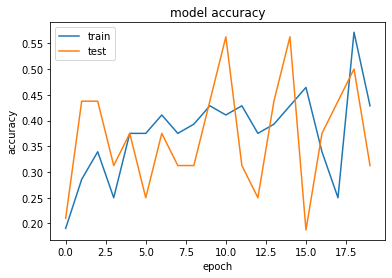

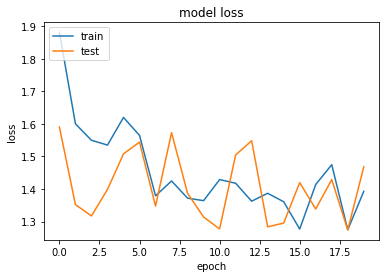

In [85]:
plot_history(history)

In [111]:
#running the model again on the sample data with the batch size 420 and frames 30
sample_train_generator,sample_val_generator=sample_data_generator(420,100)
sample_num_train_sequences,sample_num_val_sequences=sample_sequences(420,100,20)
sample_steps_per_epoch,sample_validation_steps=sample_steps(sample_num_train_sequences,sample_num_val_sequences)

# training sequences = 420
# validation sequences = 100
# epochs = 20


In [112]:
transfer_learning_model=vgg_model()
optimiser = tf.keras.optimizers.Adam(0.005)    #write your optimizer
transfer_learning_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (transfer_learning_model.summary())

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 30, 140, 140, 3)  0         
                             ]                                   
                                                                 
 time_distributed_47 (TimeDi  (None, 30, 512)          14714688  
 stributed)                                                      
                                                                 
 lstm_6 (LSTM)               (None, 256)               787456    
                                                                 
 dense_30 (Dense)            (None, 1024)              263168    
                                                                 
 dense_31 (Dense)            (None, 5)                 5125      
                                                                 
Total params: 15,770,437
Trainable params: 1,055,749
Non-tr

In [113]:
#images per video->x=30,batchsize=20
history=transfer_learning_model.fit(sample_train_generator, steps_per_epoch=sample_steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=sample_val_generator, 
                    validation_steps=sample_validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Cv-data/Project_data/train ; batch size = 20
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.7546 - categorical_accuracy: 0.2476Source path =  /content/drive/MyDrive/Cv-data/Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2022-05-1811_30_18.595344/model-00001-1.75461-0.24762-1.44034-0.42000.h5
21/21 [==============================] - 304s 15s/step - loss: 1.7546 - categorical_accuracy: 0.2476 - val_loss: 1.4403 - val_categorical_accuracy: 0.4200 - lr: 0.0050
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.4347 - categorical_accuracy: 0.3762
Epoch 2: saving model to model_init_2022-05-1811_30_18.595344/model-00002-1.43468-0.37619-1.32494-0.40000.h5
21/21 [==============================] - 76s 4s/step - loss: 1.4347 - categorical_accuracy: 0.3762 - val_loss: 1.3249 - val_categorical_accuracy: 0.4000 - lr: 0.0050
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.21

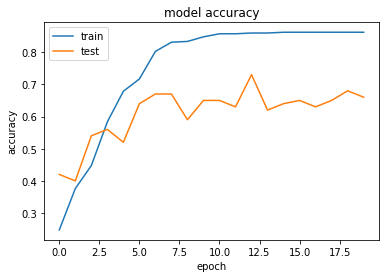

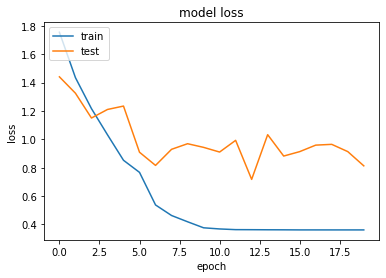

In [114]:
plot_history(history)

**Model9:**Retraining the mobinet with the batch size of 20 and frame size of 30

In [117]:
mobilenet_model=mobilenet_model()

In [118]:
mobilenet_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_48 (TimeDi  (None, 30, 4, 4, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_49 (TimeDi  (None, 30, 4, 4, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_50 (TimeDi  (None, 30, 2, 2, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_51 (TimeDi  (None, 30, 4096)         0         
 stributed)                                                      
                                                                 
 gru_2 (GRU)                 (None, 64)               

In [120]:

optimiser = tf.keras.optimizers.Adam(lr=0.0005)
mobilenet_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [121]:
sample_train_generator,sample_val_generator=sample_data_generator(420,100)
sample_num_train_sequences,sample_num_val_sequences=sample_sequences(420,100,20)
sample_steps_per_epoch,sample_validation_steps=sample_steps(sample_num_train_sequences,sample_num_val_sequences)

# training sequences = 420
# validation sequences = 100
# epochs = 20


In [122]:
#images per video->x=30,batchsize=20
history=mobilenet_model.fit(sample_train_generator, steps_per_epoch=sample_steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=sample_val_generator, 
                    validation_steps=sample_validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Cv-data/Project_data/train ; batch size = 20
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.8175 - categorical_accuracy: 0.2690Source path =  /content/drive/MyDrive/Cv-data/Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2022-05-1811_30_18.595344/model-00001-1.81749-0.26905-1.44207-0.38000.h5
21/21 [==============================] - 83s 4s/step - loss: 1.8175 - categorical_accuracy: 0.2690 - val_loss: 1.4421 - val_categorical_accuracy: 0.3800 - lr: 5.0000e-04
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.3971 - categorical_accuracy: 0.4500
Epoch 2: saving model to model_init_2022-05-1811_30_18.595344/model-00002-1.39711-0.45000-1.22181-0.58000.h5
21/21 [==============================] - 75s 4s/step - loss: 1.3971 - categorical_accuracy: 0.4500 - val_loss: 1.2218 - val_categorical_accuracy: 0.5800 - lr: 5.0000e-04
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss

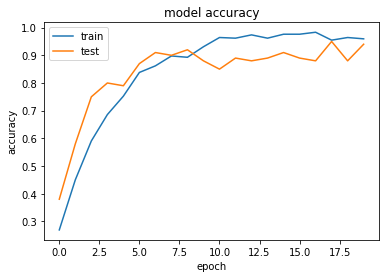

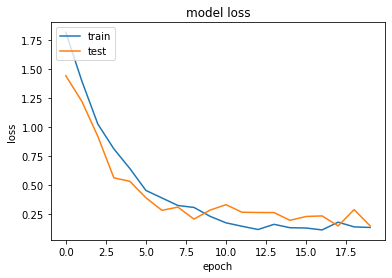

In [123]:
plot_history(history)

**Model9 conclusion:**when comapred to the vgg net the mobilent transfer learning has higher accuracy so when can consider it has our final model for prediction

**Model10:**Evaluating the conv_lstm model with batch size 20 and frames size 30

In [ ]:
conv_lstm=conv_lstm()

In [132]:
conv_lstm.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_52 (TimeDi  (None, 30, 140, 140, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_53 (TimeDi  (None, 30, 140, 140, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_54 (TimeDi  (None, 30, 70, 70, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_55 (TimeDi  (None, 30, 70, 70, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_56 (TimeDi  (None, 30, 70, 70, 32) 

In [133]:
optimiser = tf.keras.optimizers.Adam(lr=0.0005)
conv_lstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [134]:
sample_train_generator,sample_val_generator=sample_data_generator(420,100)
sample_num_train_sequences,sample_num_val_sequences=sample_sequences(420,100,20)
sample_steps_per_epoch,sample_validation_steps=sample_steps(sample_num_train_sequences,sample_num_val_sequences)

# training sequences = 420
# validation sequences = 100
# epochs = 20


In [135]:
#images per video->x=30,batchsize=20
history=conv_lstm.fit(sample_train_generator, steps_per_epoch=sample_steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=sample_val_generator, 
                    validation_steps=sample_validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Cv-data/Project_data/train ; batch size = 20
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.5108 - categorical_accuracy: 0.3333
Epoch 1: saving model to model_init_2022-05-1811_30_18.595344/model-00001-1.51084-0.33333-1.64769-0.27000.h5
21/21 [==============================] - 80s 4s/step - loss: 1.5108 - categorical_accuracy: 0.3333 - val_loss: 1.6477 - val_categorical_accuracy: 0.2700 - lr: 5.0000e-04
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.4436 - categorical_accuracy: 0.3524
Epoch 2: saving model to model_init_2022-05-1811_30_18.595344/model-00002-1.44358-0.35238-1.67487-0.24000.h5
21/21 [==============================] - 75s 4s/step - loss: 1.4436 - categorical_accuracy: 0.3524 - val_loss: 1.6749 - val_categorical_accuracy: 0.2400 - lr: 5.0000e-04
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.4650 - categorical_accuracy: 0.3714
Epoch 3: saving model to model_init_2022-

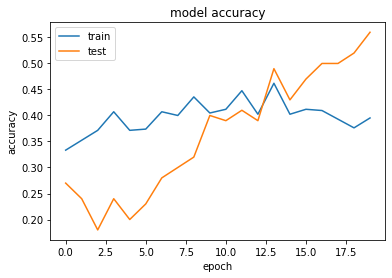

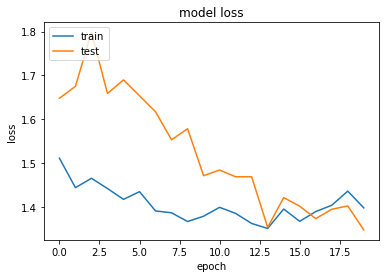

In [136]:
plot_history(history)